# Defining Defects 

A persistent challenge with organizing computational defect data is the ambiguity with which a defect simulation is defined.
The standard practice is to simulate the isolated defects by using a larger simultion to create an isolated defect and then using charge-state corrections to approximate the properties of a defect in the dilute limit.
This means that the same defect can be simulated with different simulation cells.
Ideally, if you want to build a computational defects database that lasts many years, you cannot rely on user-supplied provanance to aggregate the data.
You must have the external method for tracking whether two calculations are for the same defect.

<div class="alert alert-block alert-info"><b>Note:</b> This is only important for large database building. For an example of this please see the Materials Project battery database which only relies on structure matching to arrive at the list of insertion electrodes.
</div>


A core concept in this packge is that a defect is defined independently of the simultion cell.
All of the information about which defect we are simulating is captured by the `Defect` object.
A point defect is defined by the Wigner-Seitz unti cell representation of the bulk material stored as a `structure` attribute and a `site` attribute that indicates where the defect is in the unit cell.
Different kinds of point defects all subclass the `Defect` objects which gives easy access to functions such as generating a cubic simulation supercell.
As along as the database or any algorithm keeps track of this `Defect` object, you can just use simple structure matching to find out if two simulations represent the same defect.


### Basic Example Using GaN

In [ ]:
from pathlib import Path
TEST_FILES = Path("../tests/test_files")

In [ ]:
from pymatgen.analysis.defects.core import Substitution, Vacancy, DefectComplex
from pymatgen.core import Structure, PeriodicSite, Species

bulk = Structure.from_file(TEST_FILES / "GaN.vasp")
if bulk.lattice == bulk.get_primitive_structure().lattice: # check that you have the primitive structure
    print("The bulk unit cell is the unique primitive WS cell")

The bulk unit cell is the unique primitive WS cell


Since the two Ga sites are equivalent the Mg substitution we derive from both should be equivalent.

In [ ]:
ga_site0 = bulk.sites[0]
ga_site1 = bulk.sites[1]
n_site0 = bulk.sites[2]
n_site1 = bulk.sites[3]

mg_site0 = PeriodicSite(Species("Mg"), ga_site0.frac_coords, bulk.lattice)
mg_site1 = PeriodicSite(Species("Mg"), ga_site1.frac_coords, bulk.lattice)

In [ ]:
mg_ga_defect0 = Substitution(structure=bulk, site=mg_site0)
mg_ga_defect1 = Substitution(structure=bulk, site=mg_site1)
if mg_ga_defect0 == mg_ga_defect1:
    print("The two Mg_Ga defects are equivalent.")

The two Mg_Ga defects are equivalent.


Equivalence here is determined using the standard StructureMatcher settings. 

```python
    def __eq__(self, __o: object) -> bool:
        """Equality operator."""
        if not isinstance(__o, Defect):
            raise TypeError("Can only compare Defects to Defects")
        sm = StructureMatcher(comparator=ElementComparator())
        return sm.fit(self.defect_structure, __o.defect_structure)
```


If you are in the situation where your lattice parameters have changed overtime (i.e. by inclusion of different functionals) you might consider using more custom maching between the defects.


In [ ]:
vac_defect0 = Vacancy(structure=bulk, site=mg_site0)
vac_defect1 = Vacancy(structure=bulk, site=n_site0)
vac_defect2 = Vacancy(structure=bulk, site=n_site1)
if vac_defect0 != vac_defect1:
    print(f"The two vacancies {vac_defect0.name} and {vac_defect1.name} are not equivalent.")
    
if vac_defect2 == vac_defect1:
    print(f"The two vacancies {vac_defect2.name} and {vac_defect1.name} are equivalent.")

The two vacancies v_Ga and v_N are not equivalent.
The two vacancies v_N and v_N are equivalent.


### Defining defect complexes

In [ ]:
def_comp0 = DefectComplex(
    defects=[mg_ga_defect0, vac_defect1]
)
def_comp1 = DefectComplex(
    defects=[mg_ga_defect1, vac_defect1]
)
def_comp2 = DefectComplex(
    defects=[mg_ga_defect1, vac_defect2]
)

The `defect_structure` for each complex is shown blow.

`def_comp0`

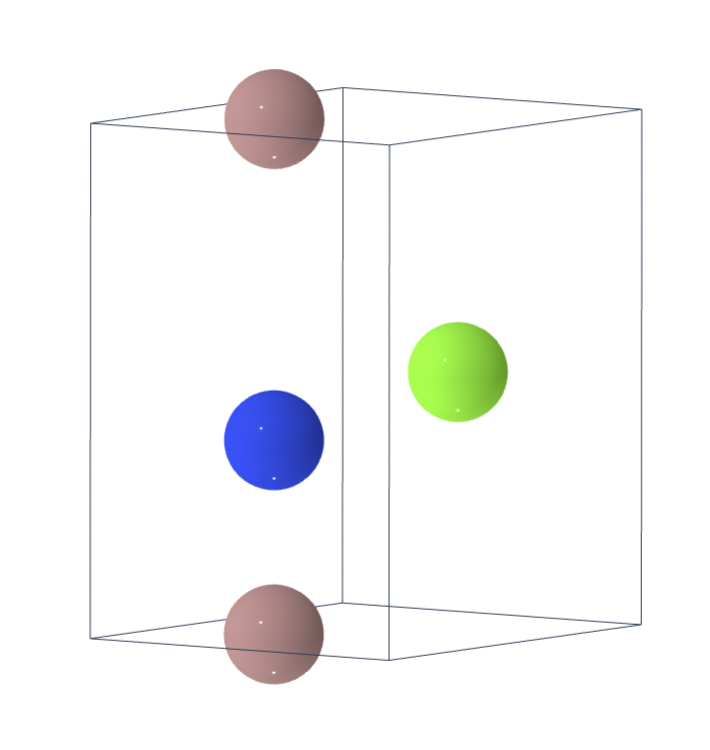

`def_comp1`

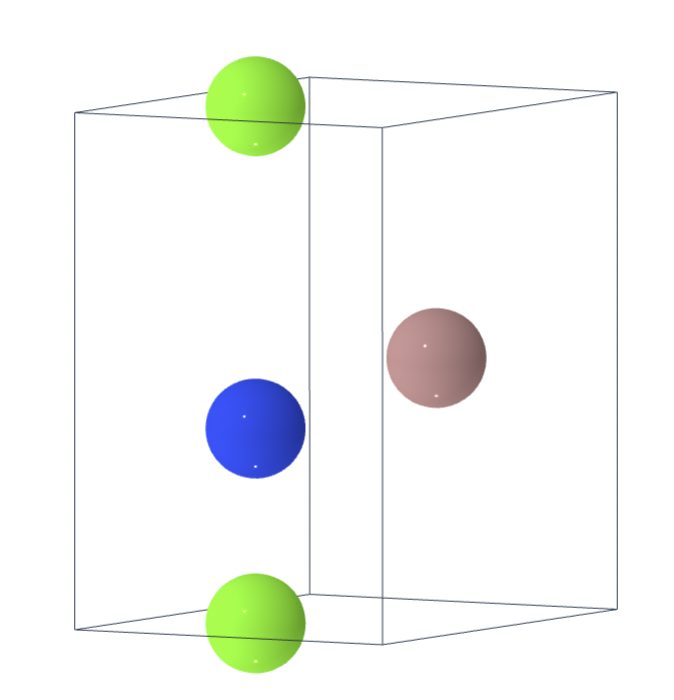

`def_comp2`

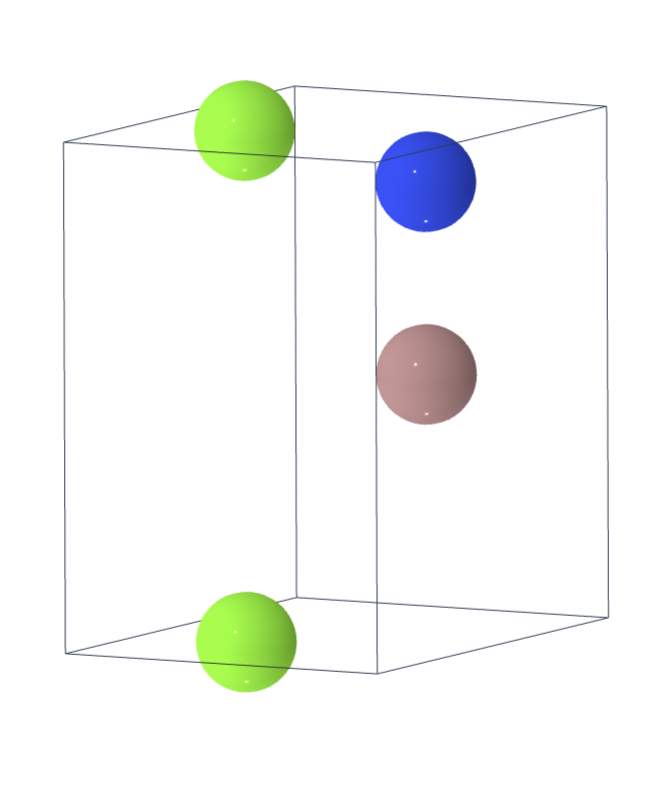


By inspection it is clear that `def_comp0` and `def_comp2` are symmetrically equivalent to each other and disinct from `def_comp1`, and our basic implementation of defect equivalence is able to verify this:

In [ ]:
assert def_comp0 == def_comp2
assert def_comp0 != def_comp1

However some defect complexes might becomse inequivalent based on the periodic image you consider for the combination of sites.

<div class="alert alert-block alert-info"><b>Note:</b> To deal with these edge cases, we might have to add a dummy "DefectComplex" species at the "center" of the defect complex which will fix the selection of periodic for the different sites.  This is easy to implement but should be done when there is a good test case.
</div>
